In [24]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt

## Functions

In [34]:
def extract_main_contour(image):
    # handle pil images by converting to array 
    if isinstance(image, Image.Image): 
        image = np.array(image)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive threshold to handle variations in color intensity
    adaptive_thresh = cv2.adaptiveThreshold(blurred, 255,
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            cv2.THRESH_BINARY_INV, 11, 2)
    
    # Apply morphological operations to clean up the image
    kernel = np.ones((15, 15), np.uint8)
    morph = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Return the largest contour
    return max(contours, key=cv2.contourArea)


# compute shape similarity between two contours
def shape_similarity(contour1, contour2):
    # matchShapes returns distance between shapes, take the inverse for similarity
    return 1/cv2.matchShapes(contour1, contour2, cv2.CONTOURS_MATCH_I1, 0.0)


# build a similarity matrix for all combinations of images
def similarity_matrix(set1, set2, names):
    matrix = np.zeros((len(set1), len(set2)))

    for i, img1 in enumerate(set1):
        img1_contour = extract_main_contour(img1)

        for j, img2 in enumerate(set2):
            img2_contour = extract_main_contour(img2)

            # compute similarity score and fill in matrix
            matrix[i, j] = shape_similarity(img1_contour, img2_contour)

    # Visualize the completed similarity matrix
    plt.imshow(matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Similarity Score')

    # Correctly label the x and y axes
    plt.xticks(ticks=range(len(set2)), labels=[f'{names[1]} sample {i+1}' for i in range(len(set2))], rotation=45)
    plt.yticks(ticks=range(len(set1)), labels=[f'{names[0]} sample {i+1}' for i in range(len(set1))])

    #plt.xlabel(names[1])  # X-axis corresponds to the second set of images
    #plt.ylabel(names[0])  # Y-axis corresponds to the first set of images

    plt.show()

    return matrix


# match images using the similarity matrix
def match(sim_matrix, row, col):
    matches = []

    # ensure that dim(row) <= dim(col)
    if len(row) > len(col):
        # transpose the matrix
        sim_matrix = sim_matrix.T

        # swap rows and columns
        row, col = col, row
    
    # traverse the rows and find the corresponding image that maximizes similarity
    for i in range(len(row)):
        # similarity score threshold
        if sim_matrix[i].max() > 2:
            matches.append((row[i], col[sim_matrix[i].argmax()]))

    return matches


# visualize matched slices
def show_matches(matches):
    for img1, img2 in matches:
        _, ax = plt.subplots(1, 2)
        
        ax[0].imshow(img1)
        ax[1].imshow(img2)

        plt.show()


# find 3-way matches
def intersect_matches(matches1, matches2):
    intersections = []
    
    for (i1, i2), (j1, j2) in product(matches1, matches2):
        imgs = [i1, j1, i2, j2]

        shapes = map(lambda x: x.shape, imgs)

        if len(set(shapes)) == 3:
            intersected = []

            for img in imgs:
                if all([img.shape != x.shape for x in intersected]):
                    intersected.append(img)
            
            intersections.append(intersected)

    return intersections

def print_similarity_scores(similarity_matrix, set1, set2, names):
    matching_indices = [] 
    # Iterate through all combinations of set1 and set2 images
    for i in range(len(set1)):
        for j in range(len(set2)):
            similarity = similarity_matrix[i, j]
            print(f"Similarity between {names[0]} sample {i+1} and {names[1]} sample {j+1}: {similarity:.4f}")

            if similarity >= 0.2:
                matching_indices.append((i, j))  # Store the (i, j) indices

    # Return the list of matching indices
    return matching_indices

def display_similar_combinations(matching_indices, set1, set2, names):
    for (i, j) in matching_indices:
        # Retrieve the images based on the indices
        img1 = set1[i]
        img2 = set2[j]

        # Display the images side by side
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        
        ax[0].imshow(img1)
        ax[0].set_title(f"{names[0]} sample {i+1}")
        ax[0].axis('off')
        
        ax[1].imshow(img2)
        ax[1].set_title(f"{names[1]} sample {j+1}")
        ax[1].axis('off')
        
        plt.show()

def pipeline(images_or_path, names):
    if isinstance(images_or_path, dict):
        images = images_or_path
    
    # Extract the sets of images for the given stain names
    set1 = images[names[0].lower()]
    set2 = images[names[1].lower()]

    # handle key error
    if set1 is None or set2 is None:
        missing_stain = names[0] if set1 is None else names[1]
        raise KeyError(f"Stain '{missing_stain}' not found in provided images dictionary.")
    
    # Compute the similarity matrix
    similarity = similarity_matrix(set1, set2, names)

    # Print similarity scores and get indices of similar samples
    # matching_indices = print_similarity_scores(similarity, set1, set2, names)
    
    # Display matching combinations
    # display_similar_combinations(matching_indices, set1, set2, names)
    
    # Match the images based on the similarity matrix
    matches = match(similarity, set1, set2)

    # Show the matched images side by side
    show_matches(matches)

    return matches


In [35]:
# pillow package 
import itertools
from PIL import Image, UnidentifiedImageError

def read(patient):
    images = {}

    # For every subfolder in a patient's folder
    for stain in os.listdir(patient):
        stain_path = os.path.join(patient, stain)
        
        # Handle non-directory files
        if not os.path.isdir(stain_path):
            continue

        # Attempt to read all files
        images[stain.lower()] = [] # standardize names
        for tissue in os.listdir(stain_path):
            try:  # Can now handle .tif files (and many more)
                img = Image.open(os.path.join(stain_path, tissue))
                images[stain].append(img)
            except UnidentifiedImageError:
                # Ignore invalid images instead of throwing error
                print(f"Warning: '{tissue}' is not a valid image file.")

    return images


def show(stains_dict, stain_names, display_samples=True):
    stains_to_show = {}
    
    # go through all the stain types requested in stain_names
    for stain in stain_names:
        if stain.lower() in stains_dict and stains_dict[stain.lower()]: # handle string inconsistency
            stains_to_show[stain] = stains_dict[stain.lower()]
        # handles error thrown when there are no images for a particular stain
        # prevents program from stopping and allows it to check for other stains 
        else:
            print(f"Warning: '{stain}' not found for the current patient or contains no valid images.")
    
    # dont throw an error when no stains are found
    if not stains_to_show:
        print("No valid stains were found.")
        return []

    # Case: only one stain type available
    if len(stains_to_show) == 1:
        stain_name = list(stains_to_show.keys())[0]

        if display_samples:
            # still show the one sample if the user requqested it
            print(f"Displaying samples for stain '{stain_name}'")
            imgs = stains_to_show[stain_name]

            fig, axes = plt.subplots(1, len(imgs), figsize=(10, 5))

            # axes is not a list (bc there is only one image)
            if len(imgs) == 1:
                axes.imshow(imgs[0])
                axes.set_title(f'{stain} sample 1')
                axes.axis('off')
            else:
                for i, img in enumerate(imgs):
                    axes[i].imshow(img)
                    axes[i].set_title(f'{stain} sample {i+1}')
                    axes[i].axis('off')
            plt.show()
            print(f"No comparisons can be made for patient with only one stain: '{stain_name}'")
        else:
            print(f"No comparisons can be made for patient with only one stain: '{stain_name}'")
        return []

    # List of possible comparisons across stains
    combinations = []
    stain_names_list = list(stains_to_show.keys())

    for stain1, stain2 in itertools.combinations(stain_names_list, 2):
        for i, img1 in enumerate(stains_to_show[stain1]):
            for j, img2 in enumerate(stains_to_show[stain2]):
                combinations.append(f"{stain1} sample {i+1} vs {stain2} sample {j+1}")
    
    # User can choose to display samples or not
    # the default behavior is to show them
    if display_samples:
        for stain, imgs in stains_to_show.items():
            print(f"Displaying samples for stain '{stain}'")

            # Using grid for flexibility
            # cols = 2 if len(imgs) > 1 else 1
            fig, axes = plt.subplots(1, len(imgs), figsize=(10, 5))
            if len(imgs) == 1:
                axes.imshow(imgs[0])
                axes.set_title(f'{stain} sample 1')
                axes.axis('off')
            else:
                for i, img in enumerate(imgs):
                    axes[i].imshow(img)
                    axes[i].set_title(f'{stain} sample {i+1}')
                    axes[i].axis('off')
            plt.show()
    
    # Show list of possible combinations
    print("Possible comparisons across stains:")
    for combination in combinations:
        print(combination)

    return 


# Test Directory Interactions

## Test Sample 1
Case where a patient only has samples in some of the requested stains. Rather than throw an error, the program now informs the user when a requested stain is not present and continues to look for samples of other requested stain types.

Displaying samples for stain 'h&e'


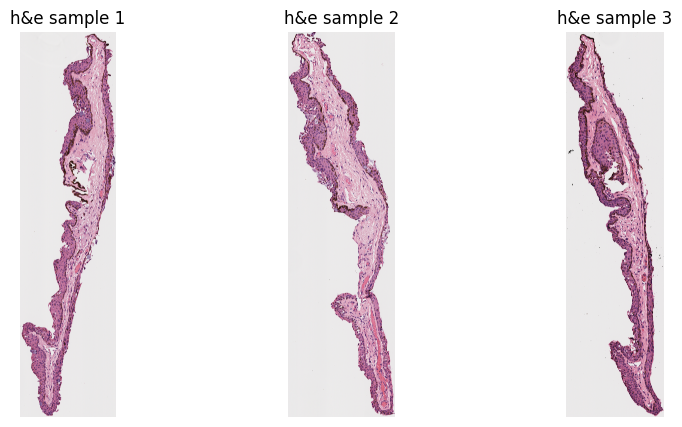

Displaying samples for stain 'melan'


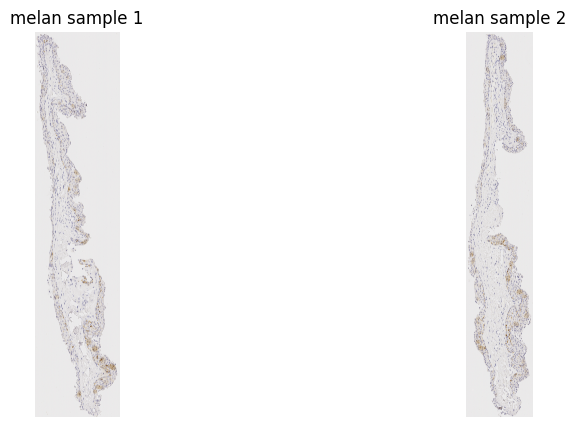

Possible comparisons across stains:
h&e sample 1 vs melan sample 1
h&e sample 1 vs melan sample 2
h&e sample 2 vs melan sample 1
h&e sample 2 vs melan sample 2
h&e sample 3 vs melan sample 1
h&e sample 3 vs melan sample 2


In [27]:
# get processed images 
images1 = read('test_samples/h2114156')

# pass in processed images along with a list of requested stains
show(images1, ['h&e', 'sox10', 'melan'])

# previous version
# show([images1['h&e'], images1['sox10']])

## Test Sample 2
All of patient 90's tissues are in the same stain (h&e), but a comparison is requested across stain types. Rather than throw an error, the given samples are (optionally) displayed along with a note that comparisons can't be made for this patient. 

Displaying samples for stain 'h&e'


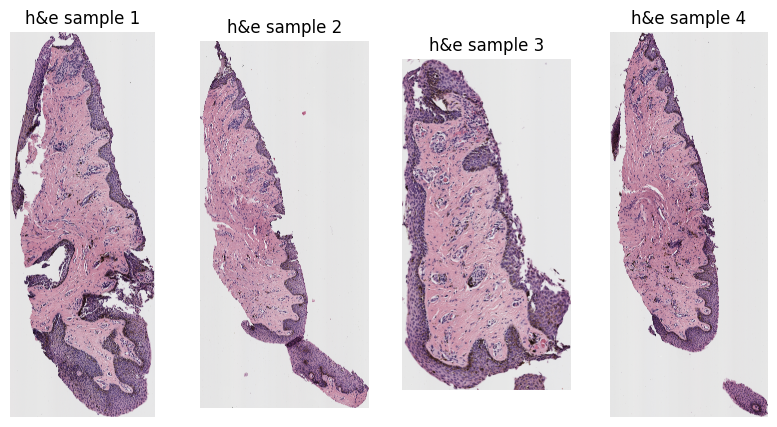

No comparisons can be made for patient with only one stain: 'h&e'


[]

In [28]:
images2 = read('test_samples/h2114190')
show(images2, ['melan', 'sox10', 'h&e'])

## Test Sample 3
Important Edge Case: Patient doesn't have samples from the first requested stain type, and has only 1 sample in another stain type. Does not stop when nothing is found for melan and processes the one available sox10 image appropriately for comparison. 

Displaying samples for stain 'sox10'


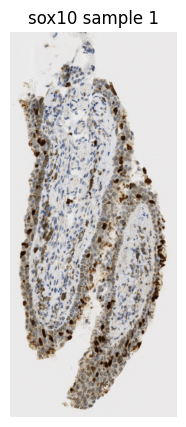

Displaying samples for stain 'h&e'


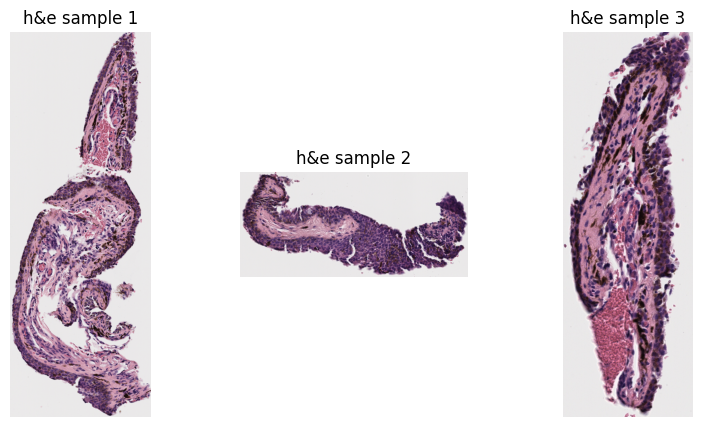

Possible comparisons across stains:
sox10 sample 1 vs h&e sample 1
sox10 sample 1 vs h&e sample 2
sox10 sample 1 vs h&e sample 3


In [29]:
images3 = read('test_samples/h2114165')
show(images3, ['melan', 'sox10', 'h&e'])

## Test Sample 4
Patient 58 only has one valid tissue sample of type sox10. Informs user accordingly. Also tests display_samples = false. 

In [30]:
images4 = read('test_samples/h2114158')
show(images4, ['melan', 'sox10', 'h&e'], display_samples=False)

No comparisons can be made for patient with only one stain: 'sox10'


[]

### Test Sample 4b
Patient 58 only has one valid tissue sample of type sox10 and it is not requested for comparison. 

In [31]:
images5 = read('test_samples/h2114158')
show(images5, ['melan', 'h&e'])

No valid stains were found.


[]

# Test Matching Functionality 
Goal: handle key errors

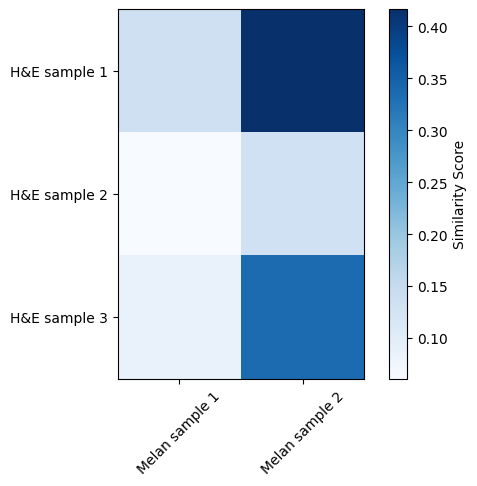

In [32]:
matched1 = pipeline(images1, ['H&E', 'Melan'])

In [36]:
matched2 = pipeline(images2, ['H&E', 'Melan'])

KeyError: 'melan'

In [ ]:
matched3 = pipeline(images3, ['Melan', 'Sox10'])

In [ ]:
matched = pipeline(images2, ['H&E', 'Melan'])

In [ ]:
for imgs in intersect_matches(matched1, matched2):
    _, ax = plt.subplots(1, len(imgs))

    for i, img in enumerate(imgs):
        ax[i].imshow(img)

    plt.show()